In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# colum names from measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# colum names from measurement
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


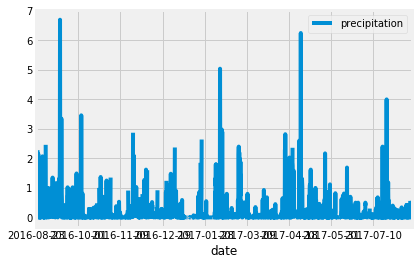

In [12]:
# # Design a query to retrieve the last 12 months of precipitation data and plot the results
# info = pd.DataFrame(engine.execute('SELECT date,prcp FROM measurement WHERE date LIKE "2017%"').fetchall())
# info.rename(columns={0:'Date', 
#                     1:'Precipitation',
#                     }, inplace=True)
# info.set_index('Date',inplace=True)
# info.sort_values(by='Date')
# info.head()
# info.plot()

# Calculate the date 1 year ago from the last data point in the database
all_df = pd.DataFrame(session.query(Measurement.date,Measurement.station, Measurement.prcp,).order_by(Measurement.date.desc()).all())
all_df.set_index('date',inplace=True)
all_df.head();
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_df = pd.DataFrame(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').all())
one_year_df.set_index('date',inplace=True)
one_year_df.rename(columns={
                   'prcp':'precipitation',
                    }, inplace=True)
# Sort the dataframe by date
one_year_df = one_year_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
one_year_df.plot()


![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
# total_stations = engine.execute('SELECT COUNT(DISTINCT station) FROM measurement').fetchall()
the_stations= engine.execute('SELECT DISTINCT station FROM measurement').fetchall()
print(f'There are {len(the_stations)} stations and they are {the_stations}')

There are 9 stations and they are [('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_stations = pd.DataFrame(engine.execute('SELECT station, COUNT("tobs") FROM measurement GROUP BY station').fetchall())
# List the stations and the counts in descending order.
most_active_stations.rename(columns={0:'Station', 
                    1:'Row count',
                    }, inplace=True)
most_active_stations.sort_values(by='Row count', ascending=False)

,Station,Row count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest and hihghest temperature recorded, 
hight = session.query(func.max(Measurement.tobs)).all()
print(f'The highest temperature recorded is {hight[0][0]}')
lowst = session.query(func.min(Measurement.tobs)).all()
print(f'The lowest temperature recorded is {lowst[0][0]}')

The highest temperature recorded is 87.0
The lowest temperature recorded is 53.0


In [17]:
USC00519523 = pd.DataFrame(session.query(Measurement.date,Measurement.tobs).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all())
len(USC00519523);
USC00519523.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


Station      USC00519523
Row count           2772
dtype: object


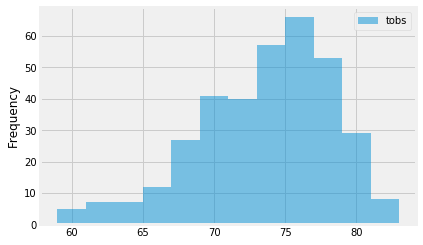

In [18]:
# Choose the station with the highest number of temperature observations.
print(most_active_stations.max());

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# .filter(Measuerment.station = USC00519523).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23')

# mst_atv_stn_12m_df
active_stn = pd.DataFrame(session.query(Measurement.date,Measurement.station, Measurement.tobs,).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all())

active_stn.plot.hist(bins=12,alpha=0.5)

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


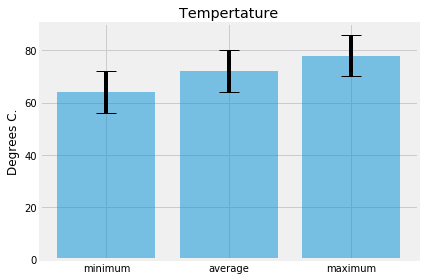

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

xlabels = ['minimum', 'average', 'maximum']

x_pos = np.arange(len(xlabels))
CTEs = [64, 72, 78]
error = [8,8,8]


fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Degrees C.')
ax.set_xticks(x_pos)
ax.set_xticklabels(xlabels)
ax.set_title('Tempertature')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()



In [22]:
# AND WHERE date <= (2017-03-05) WHERE date >= (2017-02-28)
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
trip_df= pd.DataFrame(engine.execute('SELECT measurement.station, SUM(measurement.prcp), station.latitude, station.longitude, station.elevation FROM measurement JOIN station using (station) GROUP BY station ORDER BY SUM(measurement.prcp) DESC').fetchall())
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_df.rename(columns={0:'Station', 
                     1:'total precipitation',
                     2: 'latitude',
                     3: 'longitude',
                     4: 'elevation'}
               , inplace=True)
trip_df


,Station,total precipitation,latitude,longitude,elevation
0,USC00516128,1068.09,21.33310,-157.80250,152.4
1,USC00519281,588.64,21.45167,-157.84889,32.9
2,USC00513117,382.62,21.42340,-157.80150,14.6
3,USC00519523,295.68,21.33556,-157.71139,19.5
4,USC00514830,234.49,21.52130,-157.83740,7.0
5,USC00519397,131.62,21.27160,-157.81680,3.0
6,USC00511918,92.68,21.31520,-157.99920,0.9
7,USC00518838,70.87,21.49920,-158.01110,306.6
8,USC00517948,43.44,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
